In [1]:
import pandas as pd

# Set the correct paths to the train and test CSV files
train_path = r"C:/Users/niyaz/Downloads/DISASTER TWEET ANALYSIS EDA, CLEANING, BERT/Data/train.csv"
test_path  = r"C:/Users/niyaz/Downloads/DISASTER TWEET ANALYSIS EDA, CLEANING, BERT/Data/test.csv"

# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
# Check columns and sample
print("Columns:", train_df.columns.tolist())
print("\nMissing values in training data:\n", train_df.isnull().sum())
print("\nMissing values in test data:\n", test_df.isnull().sum())


Columns: ['id', 'keyword', 'location', 'text', 'target']

Missing values in training data:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test data:
 id             0
keyword       26
location    1105
text           0
dtype: int64


<Axes: title={'center': 'Target Class Distribution (0 = Not Disaster, 1 = Disaster)'}, xlabel='target'>

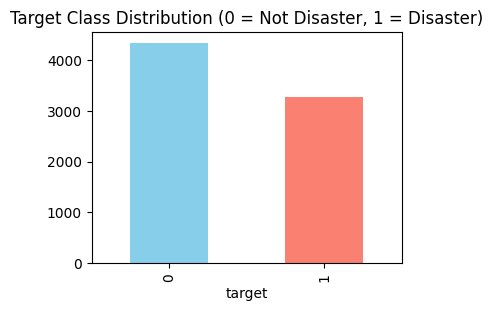

In [3]:
# Distribution of target classes
train_df['target'].value_counts().plot(
    kind='bar',
    color=['skyblue','salmon'],
    figsize=(4,3),
    title='Target Class Distribution (0 = Not Disaster, 1 = Disaster)'
)


In [4]:
disaster_count = train_df['target'].sum()
non_disaster_count = len(train_df) - disaster_count
print(f"Disaster tweets: {disaster_count} ({disaster_count/len(train_df)*100:.2f}%)")
print(f"Not disaster tweets: {non_disaster_count} ({non_disaster_count/len(train_df)*100:.2f}%)")


Disaster tweets: 3271 (42.97%)
Not disaster tweets: 4342 (57.03%)


In [5]:
# Add length features for EDA
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
train_df['avg_word_length'] = train_df['char_count'] / train_df['word_count']

print(train_df[['word_count','char_count','avg_word_length']].describe())


        word_count   char_count  avg_word_length
count  7613.000000  7613.000000      7613.000000
mean     14.903586   101.037436         7.054136
std       5.732604    33.781325         1.660895
min       1.000000     7.000000         3.000000
25%      11.000000    78.000000         5.818182
50%      15.000000   107.000000         6.857143
75%      19.000000   133.000000         8.000000
max      31.000000   157.000000        20.166667


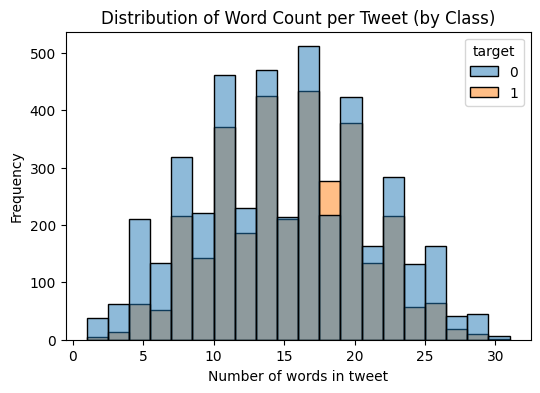

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(data=train_df, x='word_count', hue='target', bins=20, kde=False)
plt.title('Distribution of Word Count per Tweet (by Class)')
plt.xlabel('Number of words in tweet')
plt.ylabel('Frequency')
plt.show()


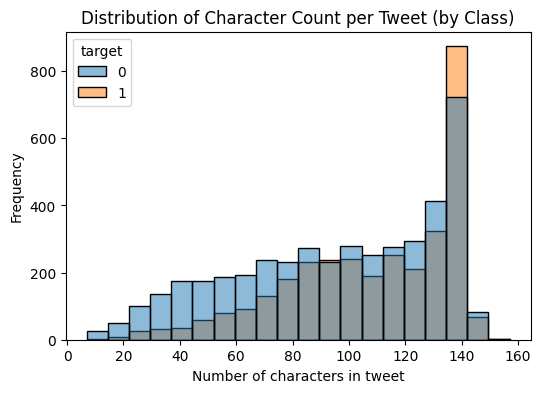

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(data=train_df, x='char_count', hue='target', bins=20, kde=False)
plt.title('Distribution of Character Count per Tweet (by Class)')
plt.xlabel('Number of characters in tweet')
plt.ylabel('Frequency')
plt.show()


In [8]:
import re
import numpy as np

# Helper: simple text cleanup for frequency analysis (lowercase and remove punctuation)
def simple_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # replace non-alphanumeric characters with space
    return text

train_df['text_clean'] = train_df['text'].apply(simple_clean)

# Split into disaster vs non-disaster sets
disaster_texts = train_df[train_df['target']==1]['text_clean']
nondisaster_texts = train_df[train_df['target']==0]['text_clean']


In [9]:
from collections import Counter

# Function to get top N words from a series of texts
def get_top_n_words(text_series, n=20):
    all_words = ' '.join(text_series.tolist()).split()
    freq = Counter(all_words)
    return freq.most_common(n)

print("Top words in disaster tweets:", get_top_n_words(disaster_texts, 10))
print("Top words in non-disaster tweets:", get_top_n_words(nondisaster_texts, 10))


Top words in disaster tweets: [('t', 2668), ('co', 2528), ('http', 2382), ('the', 1367), ('in', 1165), ('a', 940), ('of', 928), ('to', 757), ('and', 507), ('on', 420)]
Top words in non-disaster tweets: [('t', 2563), ('co', 2212), ('http', 1927), ('the', 1917), ('i', 1394), ('a', 1269), ('to', 1192), ('and', 920), ('of', 902), ('in', 824)]


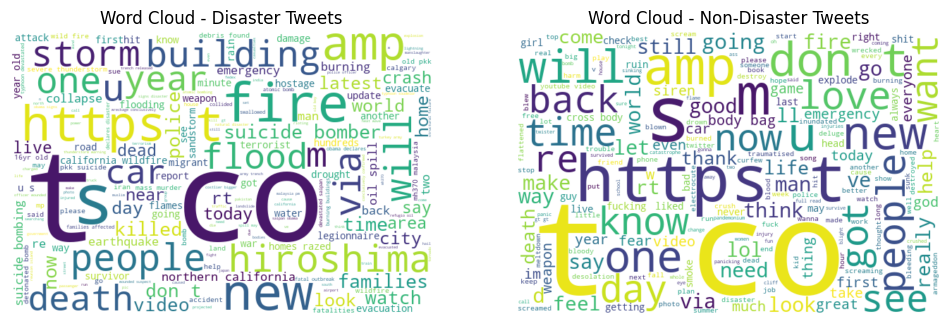

In [10]:
# Install wordcloud if not already installed (in case using a fresh environment)
# !pip install wordcloud   # (uncomment if needed)

from wordcloud import WordCloud

# Generate word cloud for disaster tweets
disaster_text = ' '.join(disaster_texts.tolist())
disaster_wc = WordCloud(width=600, height=400, background_color='white').generate(disaster_text)

# Generate word cloud for non-disaster tweets
nondis_text = ' '.join(nondisaster_texts.tolist())
nondisaster_wc = WordCloud(width=600, height=400, background_color='white').generate(nondis_text)

# Plot the word clouds
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(disaster_wc, interpolation='bilinear')
ax[0].set_title("Word Cloud - Disaster Tweets")
ax[0].axis('off')
ax[1].imshow(nondisaster_wc, interpolation='bilinear')
ax[1].set_title("Word Cloud - Non-Disaster Tweets")
ax[1].axis('off')
plt.show()


In [11]:
from itertools import islice

def get_top_n_bigrams(text_series, n=20):
    all_words = ' '.join(text_series.tolist()).split()
    bigrams = zip(all_words, islice(all_words, 1, None))
    freq = Counter(bigrams)
    return freq.most_common(n)

print("Top bigrams in disaster tweets:", get_top_n_bigrams(disaster_texts, 10))
print("Top bigrams in non-disaster tweets:", get_top_n_bigrams(nondisaster_texts, 10))


Top bigrams in disaster tweets: [(('t', 'co'), 2517), (('http', 't'), 2382), (('in', 'the'), 145), (('https', 't'), 135), (('of', 'the'), 119), (('it', 's'), 64), (('suicide', 'bomber'), 59), (('don', 't'), 51), (('on', 'the'), 51), (('in', 'a'), 50)]
Top bigrams in non-disaster tweets: [(('t', 'co'), 2200), (('http', 't'), 1926), (('https', 't'), 276), (('i', 'm'), 207), (('in', 'the'), 163), (('don', 't'), 139), (('of', 'the'), 137), (('it', 's'), 134), (('to', 'the'), 90), (('on', 'the'), 81)]


In [12]:
# Most frequent keywords
print(train_df['keyword'].value_counts().head(10))

# Check how a specific keyword correlates with target, e.g., "fatalities"
print(train_df[train_df['keyword']=="fatalities"]['target'].value_counts())


keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64
target
1    26
0    19
Name: count, dtype: int64


In [13]:
import re
import html
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define a dictionary for common contractions and their expansions
contractions = {
    "don't": "do not", "dont": "do not", 
    "can't": "cannot", "cant": "cannot",
    "won't": "will not", "wont": "will not",
    "you're": "you are", "youre": "you are",
    "i'm": "i am", "im": "i am",
    "we're": "we are", "were": "we are",
    "that's": "that is", "thats": "that is",
    "it's": "it is", "its": "it is",
    "doesn't": "does not", "doesnt": "does not",
    "isn't": "is not", "isnt": "is not",
    "couldn't": "could not", "couldnt": "could not",
    "didn't": "did not", "didnt": "did not",
    "wouldn't": "would not", "wouldnt": "would not",
    "haven't": "have not", "havent": "have not",
    "hadn't": "had not", "hadnt": "had not",
    "shouldn't": "should not", "shouldnt": "should not",
    "wasn't": "was not", "wasnt": "was not",
    "weren't": "were not", "werent": "were not",
    "ain't": "is not", "aint": "is not",
    "mightn't": "might not", "mightnt": "might not",
    "you'll": "you will", "youll": "you will",
    "he's": "he is", "hes": "he is",
    "she's": "she is", "shes": "she is",
    "i've": "i have", "ive": "i have",
    "they're": "they are", "theyre": "they are",
    "we've": "we have", "weve": "we have",
    "what's": "what is", "whats": "what is",
    "could've": "could have", "couldve": "could have",
    "should've": "should have", "shouldve": "should have",
    "would've": "would have", "wouldve": "would have"
}

stop_words = ENGLISH_STOP_WORDS  # set of stopwords

def clean_text(text):
    # Decode HTML entities (&amp; -> &, etc)
    text = html.unescape(str(text))
    # Lowercase
    text = text.lower()
    # Remove URLs (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions (@usernames)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtag symbol (#) but keep the text
    text = text.replace('#', '')
    # Expand contractions
    tokens = text.split()
    tokens = [contractions[t] if t in contractions else t for t in tokens]
    text = " ".join(tokens)
    # Remove non-alphanumeric characters (retain letters, numbers, whitespace)
    text = re.sub(r'[^0-9a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    text = " ".join(tokens)
    return text

# Apply cleaning to training and test text
train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean']  = test_df['text'].apply(clean_text)


In [14]:
sample_text = "OMG! The hurricane is coming!!! Check this out: https://t.co/xyz @JohnDoe #disaster #BreakingNews don't worry 😉"
print("Original text: ", sample_text)
print("Cleaned text:  ", clean_text(sample_text))


Original text:  OMG! The hurricane is coming!!! Check this out: https://t.co/xyz @JohnDoe #disaster #BreakingNews don't worry 😉
Cleaned text:   omg hurricane coming check disaster breakingnews worry


In [15]:
import string

# Punctuation count in original text
train_df['punct_count'] = train_df['text'].apply(lambda x: sum(1 for ch in str(x) if ch in string.punctuation))
# Hashtag count and mention count in original text
train_df['hashtag_count'] = train_df['text'].apply(lambda x: str(x).count('#'))
train_df['mention_count'] = train_df['text'].apply(lambda x: str(x).count('@'))

# Do the same for test data
test_df['punct_count'] = test_df['text'].apply(lambda x: sum(1 for ch in str(x) if ch in string.punctuation))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: str(x).count('#'))
test_df['mention_count'] = test_df['text'].apply(lambda x: str(x).count('@'))

# Quick overview of new features
train_df[['word_count','char_count','punct_count','hashtag_count','mention_count']].describe()


,word_count,char_count,punct_count,hashtag_count,mention_count
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,14.903586,101.037436,6.839485,0.446999,0.362406
std,5.732604,33.781325,4.608758,1.099841,0.720097
min,1.000000,7.000000,0.000000,0.000000,0.000000
25%,11.000000,78.000000,3.000000,0.000000,0.000000
50%,15.000000,107.000000,6.000000,0.000000,0.000000
75%,19.000000,133.000000,10.000000,0.000000,1.000000
max,31.000000,157.000000,61.000000,13.000000,8.000000


In [16]:
print(train_df.groupby('target')['punct_count'].mean())
print(train_df.groupby('target')['hashtag_count'].mean())
print(train_df.groupby('target')['mention_count'].mean())


target
0    6.309074
1    7.543565
Name: punct_count, dtype: float64
target
0    0.391525
1    0.520636
Name: hashtag_count, dtype: float64
target
0    0.426992
1    0.276674
Name: mention_count, dtype: float64


In [17]:
# Placeholder paths for embedding files (update these if you have the files)
glove_path = "glove.6B.100d.txt"       # e.g., 'glove.6B.100d.txt'
fasttext_path = "wiki-news-300d-1M.vec" # e.g., 'wiki-news-300d-1M.vec'

# Load GloVe embeddings (this can take a while for large files)
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Load FastText embeddings (if using .vec format)
fasttext_embeddings = {}
with open(fasttext_path, 'r', encoding='utf-8') as f:
    next(f)  # skip header line if present
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        fasttext_embeddings[word] = vector

# Get vocabulary from our cleaned text
vocab = set(' '.join(train_df['text_clean']).split())
print("Vocabulary size (train tweets):", len(vocab))

# Calculate coverage (if embeddings loaded)
known_glove = [w for w in vocab if w in glove_embeddings]
unknown_glove = [w for w in vocab if w not in glove_embeddings]
print(f"GloVe coverage: {len(known_glove)}/{len(vocab)} words ({len(known_glove)/len(vocab)*100:.2f}%)")

known_fasttext = [w for w in vocab if w in fasttext_embeddings]
unknown_fasttext = [w for w in vocab if w not in fasttext_embeddings]
print(f"FastText coverage: {len(known_fasttext)}/{len(vocab)} words ({len(known_fasttext)/len(vocab)*100:.2f}%)")


Vocabulary size (train tweets): 15241
GloVe coverage: 12071/15241 words (79.20%)
FastText coverage: 11713/15241 words (76.85%)


In [18]:
from transformers import BertTokenizer

MAX_LEN = 64  # maximum tweet length (in tokens) to pad/truncate to; 64 is sufficient for our tweets (max ~34 words as observed)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and test texts
train_encodings = tokenizer(
    train_df['text_clean'].tolist(), 
    truncation=True, padding=True, max_length=MAX_LEN
)
test_encodings = tokenizer(
    test_df['text_clean'].tolist(), 
    truncation=True, padding=True, max_length=MAX_LEN
)

# Extract encoded arrays
X_ids = np.array(train_encodings['input_ids'])
X_mask = np.array(train_encodings['attention_mask'])
X_type = np.array(train_encodings['token_type_ids'])  # token type IDs (for single sentence, this will be all zeros)
y = train_df['target'].values

print("Encoded input shapes:", X_ids.shape, X_mask.shape, X_type.shape)
print("Example tokenized sequence for first tweet:")
print("Text:", train_df['text_clean'].iloc[0])
print("Tokens:", tokenizer.tokenize(train_df['text_clean'].iloc[0]))
print("Token IDs:", X_ids[0])
print("Attention Mask:", X_mask[0])


c:\Users\niyaz\anaconda3\envs\nlp-tf\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encoded input shapes: (7613, 52) (7613, 52) (7613, 52)
Example tokenized sequence for first tweet:
Text: deeds reason earthquake allah forgive
Tokens: ['deeds', 'reason', 'earthquake', 'allah', 'forgive']
Token IDs: [  101 15616  3114  8372 16455  9641   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Attention Mask: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:


import tensorflow as tf

from transformers import TFBertForSequenceClassification

# Define model building function (to get a fresh model each fold)
def create_model():
    # Clear any previous model/graph from memory
    tf.keras.backend.clear_session()

    # Load pre-trained BERT for sequence classification
    model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        from_pt=False
    )

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  # BERT fine-tune LR
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

# Create model instance
model = create_model()
model.summary()


RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
module 'tensorflow._api.v2.compat.v2.__internal__' has no attribute 'register_load_context_function'

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prepare for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 5
cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1 = []

histories = []  # to store training history of each fold for later analysis

for train_index, val_index in skf.split(X_ids, y):
    print(f"\n### Fold {fold} ###")
    X_train_ids, X_val_ids = X_ids[train_index], X_ids[val_index]
    X_train_mask, X_val_mask = X_mask[train_index], X_mask[val_index]
    X_train_type, X_val_type = X_type[train_index], X_type[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Initialize new model for each fold
    model = create_model()
    
    # Train the model
    history = model.fit(
        [X_train_ids, X_train_mask, X_train_type], y_train,
        validation_data=([X_val_ids, X_val_mask, X_val_type], y_val),
        epochs=3,
        batch_size=32  # adjust based on memory (16 or 32 are common)
    )
    histories.append(history)
    
    # Predict on validation set
    val_preds = model.predict([X_val_ids, X_val_mask, X_val_type])
    # val_preds will be a tuple (logits, ) from TFBertForSequenceClassification
    val_logits = val_preds.logits  if hasattr(val_preds, 'logits') else val_preds[0]
    # Convert logits to class predictions
    val_pred_labels = np.argmax(val_logits, axis=1)
    
    # Compute metrics
    acc = accuracy_score(y_val, val_pred_labels)
    prec = precision_score(y_val, val_pred_labels, average='binary')
    rec = recall_score(y_val, val_pred_labels, average='binary')
    f1 = f1_score(y_val, val_pred_labels, average='binary')
    cv_accuracy.append(acc)
    cv_precision.append(prec)
    cv_recall.append(rec)
    cv_f1.append(f1)
    
    print(f"Fold {fold} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    fold += 1

# Average performance across folds
print("\nAverage CV Accuracy: {:.4f}".format(np.mean(cv_accuracy)))
print("Average CV Precision: {:.4f}".format(np.mean(cv_precision)))
print("Average CV Recall: {:.4f}".format(np.mean(cv_recall)))
print("Average CV F1-score: {:.4f}".format(np.mean(cv_f1)))



In [ ]:
# Plot learning curve for the last fold (fold 5 in this case)
history = histories[-1]

epochs = range(1, len(history.history['loss'])+1)
plt.figure(figsize=(6,4))
plt.plot(epochs, history.history['loss'], 'bo--', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, history.history['accuracy'], 'bo--', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Final training on all data (if needed, e.g., for competition submission)
final_model = create_model()
final_model.fit([X_ids, X_mask, X_type], y, epochs=3, batch_size=16)
# Predict on test data
test_preds = final_model.predict([np.array(test_encodings['input_ids']),
                                  np.array(test_encodings['attention_mask']),
                                  np.array(test_encodings['token_type_ids'])])
test_logits = test_preds.logits if hasattr(test_preds, 'logits') else test_preds[0]
test_pred_labels = np.argmax(test_logits, axis=1)
# Create submission file
submission = pd.DataFrame({'id': test_df['id'], 'target': test_pred_labels})
submission.to_csv('submission.csv', index=False)
